In [1]:
import optuna 

In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
aFRR Price Forecasting - Preprocessing Module

This module handles data loading, preparation, and preprocessing for aFRR price forecasting.
It can be used as a standalone module in Jupyter notebooks or imported by other modules.
"""

# Standard libraries
import warnings
import logging
import numpy as np
import pandas as pd

# Custom modules
from utils.ssa import mySSA
from darts import TimeSeries
from darts.dataprocessing import Pipeline
from darts.dataprocessing.transformers import MissingValuesFiller, Scaler

warnings.filterwarnings("ignore")
logging.disable(logging.CRITICAL)


def load_and_prepare_data(data_path=None):
    """
    Load and prepare the aFRR price data.
    
    Args:
        data_path (str): Path to the parquet file containing aFRR price data
        
    Returns:
        pd.DataFrame: Prepared dataframe with aFRR price data
    """
    data = pd.read_parquet(data_path)
    
    data = data[['wind_offshore_dayahead', 'wind_onshore_dayahead',
           'solar_dayahead','aFRR_DownCapPriceEUR', 'aFRR_UpCapPriceEUR', 'load_forecasts',
           'da_price', 'prod_unbalance']]
    
    data.index = data.index.tz_localize(None)
    
    return data


def apply_ssa_decomposition(data):
    """
    Apply Singular Spectrum Analysis (SSA) decomposition to the target variable.
    
    Args:
        data (pd.DataFrame): DataFrame containing aFRR price data
        
    Returns:
        pd.DataFrame: DataFrame with added cleaned aFRR price column
    """
    ts = data["aFRR_UpCapPriceEUR"]
    ssa_ts = mySSA(data["aFRR_UpCapPriceEUR"])
    ssa_ts.embed(embedding_dimension=128, suspected_frequency=24, verbose=True)
    ssa_ts.decompose(True)
    
    # Components to use for reconstruction (to tune for optimal decomposition)
    components = [i for i in range(15)]
    ts_clean = ssa_ts.view_reconstruction(*[ssa_ts.Xs[i] for i in components], names=components, return_df=True, plot=False)
    
    data["aFRR_UpCapPriceEUR_cl"] = ts_clean.values
    
    return data


def prepare_time_series(data):
    """
    Convert data to Darts TimeSeries objects and preprocess.
    
    Args:
        data (pd.DataFrame): DataFrame containing aFRR price data
        
    Returns:
        tuple: Tuple containing:
            - afrr_pr_ts_scl (TimeSeries): Scaled target series
            - afrr_pr_ts_orig (TimeSeries): Original target series
            - exog_ts_scl (TimeSeries): Scaled exogenous variables
            - afrr_pr_scaler (Pipeline): Scaler for target variable
    """
    afrr_pr = 'aFRR_UpCapPriceEUR_cl'
    afrr_pr_orig = 'aFRR_UpCapPriceEUR'
    
    exog_cols = ['wind_offshore_dayahead', 'wind_onshore_dayahead', 
                'solar_dayahead', 'load_forecasts', 'da_price', 'prod_unbalance']
    
    afrr_pr_ts = TimeSeries.from_series(data[afrr_pr], freq="1h")
    afrr_pr_ts_orig = TimeSeries.from_series(data[afrr_pr_orig], freq="1h")
    exog_ts = TimeSeries.from_dataframe(data[exog_cols], freq="1h")
    
    # Setup preprocessing pipelines
    scaler_target_ts = Scaler()
    scaler_exog_ts = Scaler()
    filler_target_ts = MissingValuesFiller()
    filler_exog_ts = MissingValuesFiller()
    
    afrr_pr_scaler = Pipeline([scaler_target_ts])
    exog_ts_preprocess = Pipeline([scaler_exog_ts])
    
    # Apply preprocessing
    afrr_pr_ts_filled = filler_target_ts.transform(afrr_pr_ts)
    exog_ts_filled = filler_exog_ts.transform(exog_ts)
    
    afrr_pr_ts_scl = afrr_pr_scaler.fit_transform(afrr_pr_ts_filled)
    exog_ts_scl = exog_ts_preprocess.fit_transform(exog_ts_filled)
    
    return afrr_pr_ts_scl, afrr_pr_ts_orig, exog_ts_scl, afrr_pr_scaler


def split_data(afrr_pr_ts_scl, afrr_pr_ts_orig, exog_ts_scl, 
               train_start="2024-10-01 22:00:00", 
               test_start="2025-01-09 22:00:00", 
               test_end="2025-02-20 22:00:00",
               val_start=None,
               use_validation=False):
    """
    Split data into training and test sets, with optional validation set.
    
    Args:
        afrr_pr_ts_scl (TimeSeries): Scaled target series
        afrr_pr_ts_orig (TimeSeries): Original target series
        exog_ts_scl (TimeSeries): Scaled exogenous variables
        train_start (str): Start date for training data
        test_start (str): Start date for test data
        test_end (str): End date for test data
        val_start (str, optional): Start date for validation data. Only used if use_validation=True.
        use_validation (bool): Whether to include a validation set in the split.
        
    Returns:
        tuple: Tuple containing split datasets. If use_validation=True, returns:
            - afrr_pr_ts_scl_train, afrr_pr_ts_scl_val, afrr_pr_ts_scl_test
            - afrr_pr_ts_orig_train, afrr_pr_ts_orig_val, afrr_pr_ts_orig_test
            - exog_ts_scl_train, exog_ts_scl_val, exog_ts_scl_test
        Otherwise returns:
            - afrr_pr_ts_scl_train, afrr_pr_ts_scl_test
            - afrr_pr_ts_orig_train, afrr_pr_ts_orig_test
            - exog_ts_scl_train, exog_ts_scl_test
    """
    # Convert string to timestamps if provided as strings
    if isinstance(train_start, str):
        train_start = pd.Timestamp(train_start)
    if isinstance(test_start, str):
        test_start = pd.Timestamp(test_start)
    if isinstance(test_end, str):
        test_end = pd.Timestamp(test_end)
    
    if use_validation:
        if val_start is None:
            # Default validation start date if not provided (halfway between train and test)
            val_start = train_start + (test_start - train_start) / 2
        elif isinstance(val_start, str):
            val_start = pd.Timestamp(val_start)
        
        # Split target series with validation
        afrr_pr_ts_scl_train = afrr_pr_ts_scl[train_start : val_start - afrr_pr_ts_scl.freq]
        afrr_pr_ts_scl_val = afrr_pr_ts_scl[val_start : test_start - afrr_pr_ts_scl.freq]
        afrr_pr_ts_scl_test = afrr_pr_ts_scl[test_start : test_end]
        
        afrr_pr_ts_orig_train = afrr_pr_ts_orig[train_start : val_start - afrr_pr_ts_orig.freq]
        afrr_pr_ts_orig_val = afrr_pr_ts_orig[val_start : test_start - afrr_pr_ts_orig.freq]
        afrr_pr_ts_orig_test = afrr_pr_ts_orig[test_start : test_end]
        
        # Split exogenous series
        exog_ts_scl_train = exog_ts_scl[train_start : val_start - exog_ts_scl.freq]
        exog_ts_scl_val = exog_ts_scl[val_start : test_start - exog_ts_scl.freq]
        exog_ts_scl_test = exog_ts_scl[test_start : test_end]
        
        return (
            afrr_pr_ts_scl_train, 
            afrr_pr_ts_scl_val,
            afrr_pr_ts_scl_test, 
            afrr_pr_ts_orig_train,
            afrr_pr_ts_orig_val, 
            afrr_pr_ts_orig_test, 
            exog_ts_scl_train,
            exog_ts_scl_val, 
            exog_ts_scl_test
        )
    else:
        # Split target series without validation
        afrr_pr_ts_scl_train = afrr_pr_ts_scl[train_start : test_start - afrr_pr_ts_scl.freq]
        afrr_pr_ts_scl_test = afrr_pr_ts_scl[test_start : test_end]
        
        afrr_pr_ts_orig_train = afrr_pr_ts_orig[train_start : test_start - afrr_pr_ts_orig.freq]
        afrr_pr_ts_orig_test = afrr_pr_ts_orig[test_start : test_end]
        
        # Split exogenous series
        exog_ts_scl_train = exog_ts_scl[train_start : test_start - exog_ts_scl.freq]
        exog_ts_scl_test = exog_ts_scl[test_start : test_end]
        
        return (
            afrr_pr_ts_scl_train, 
            afrr_pr_ts_scl_test, 
            afrr_pr_ts_orig_train, 
            afrr_pr_ts_orig_test, 
            exog_ts_scl_train, 
            exog_ts_scl_test
        )


def preprocess_afrr_data(data_path=None,
                         train_start=None, 
                         test_start=None, 
                         test_end=None,
                         val_start=None,
                         use_validation=False):
    """
    Complete preprocessing pipeline for aFRR data.
    
    Args:
        data_path (str): Path to the parquet file containing aFRR price data
        train_start (str): Start date for training data
        test_start (str): Start date for test data
        test_end (str): End date for test data
        val_start (str, optional): Start date for validation data. Only used if use_validation=True.
        use_validation (bool): Whether to include a validation set in the split.
        
    Returns:
        tuple: Tuple containing all necessary data for modeling. If use_validation=True, returns:
            - afrr_pr_ts_scl_train, afrr_pr_ts_scl_val, afrr_pr_ts_scl_test
            - afrr_pr_ts_orig_train, afrr_pr_ts_orig_val, afrr_pr_ts_orig_test
            - exog_ts_scl_train, exog_ts_scl_val, exog_ts_scl_test, afrr_pr_scaler
        Otherwise returns:
            - afrr_pr_ts_scl_train, afrr_pr_ts_scl_test
            - afrr_pr_ts_orig_train, afrr_pr_ts_orig_test
            - exog_ts_scl_train, exog_ts_scl_test, afrr_pr_scaler
    """
    # Load and prepare data
    data = load_and_prepare_data(data_path)
    
    # Apply SSA decomposition
    data = apply_ssa_decomposition(data)
    
    # Prepare time series
    afrr_pr_ts_scl, afrr_pr_ts_orig, exog_ts_scl, afrr_pr_scaler = prepare_time_series(data)
    
    # Split data
    splits = split_data(
        afrr_pr_ts_scl, 
        afrr_pr_ts_orig, 
        exog_ts_scl,
        train_start,
        test_start,
        test_end,
        val_start,
        use_validation
    )
    
    # Return all components needed for modeling
    return (*splits, afrr_pr_scaler)

In [2]:
(
    afrr_pr_ts_scl_train, afrr_pr_ts_scl_val,
    afrr_pr_ts_scl_test, afrr_pr_ts_orig_train,
    afrr_pr_ts_orig_val, afrr_pr_ts_orig_test, 
    exog_ts_scl_train, exog_ts_scl_val, exog_ts_scl_test,
    afrr_pr_scaler
) = preprocess_afrr_data(
    data_path='/home/alqua/git/boiler_OptiBid/data/afrr_price.parquet',
    train_start="2024-10-10 00:00:00",
    val_start="2025-01-01 00:00:00",
    test_start="2025-03-01 00:00:00",
    test_end="2025-04-09 00:00:00", 
    use_validation=True)

----------------------------------------
EMBEDDING SUMMARY:
Embedding dimension	:  120
Trajectory dimensions	: (120, 3672)
Complete dimension	: (120, 3672)
Missing dimension     	: (120, 0)
----------------------------------------
DECOMPOSITION SUMMARY:
Rank of trajectory		: 120
Dimension of projection space	: 114
Characteristic of projection	: 0.9997


----------------------------------------
EMBEDDING SUMMARY:
Embedding dimension	:  120
Trajectory dimensions	: (120, 4390)
Complete dimension	: (120, 4390)
Missing dimension     	: (120, 0)
----------------------------------------
DECOMPOSITION SUMMARY:
Rank of trajectory		: 120
Dimension of projection space	: 120
Characteristic of projection	: 1.0


  0%|          | 0/10 [00:00<?, ?it/s]

Best parameters for LR model: {'lags_max': 226, 'lags_past_covariates_max': 105}
Best validation RMSE: 0.22740534618331393
Historical Forecast Using Fitted LR Model...


historical forecasts:   0%|          | 0/1 [00:00<?, ?it/s]

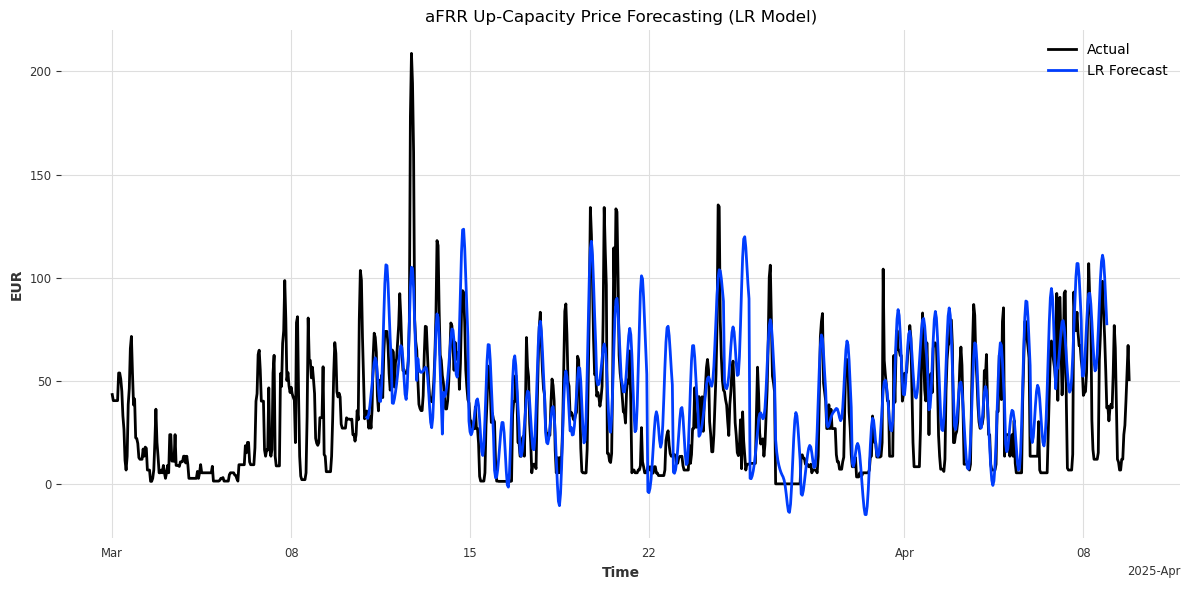

ValueError: `actual_series` must be strictly positive to compute the MAPE.

In [3]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
Linear Regression model for aFRR Price Forecasting

This standalone module handles optimization and training for Linear Regression models
using a validation set for hyperparameter tuning.
"""
import optuna
from optuna.samplers import TPESampler
from darts.timeseries import concatenate
from darts.models import LinearRegressionModel
#from utils.afrr_preprocessing import preprocess_afrr_data
from utils.forecast_utils import save_model_results, generate_historical_forecasts, plot_results
from darts.metrics import rmse


def optimize_model(afrr_pr_ts_scl_train, afrr_pr_ts_scl_val, exog_ts_scl_train, exog_ts_scl_val, output_chunk_length, n_trials):
    """
    Optimize Linear Regression model hyperparameters using validation set.
    
    Args:
        afrr_pr_ts_scl_train (TimeSeries): Training target data
        afrr_pr_ts_scl_val (TimeSeries): Validation target data
        exog_ts_scl_train (TimeSeries): Training exogenous data
        exog_ts_scl_val (TimeSeries): Validation exogenous data
        output_chunk_length (int): Output chunk length
        n_trials (int): Number of optimization trials
        
    Returns:
        dict: Best hyperparameters
    """
    def objective(trial):
        # Optimize lags
        lags_max = trial.suggest_int("lags_max", 100, 400)
        lags_past_covariates_max = trial.suggest_int("lags_past_covariates_max", 50, 150)
        
        # Create and train model
        model = LinearRegressionModel(
            output_chunk_length=output_chunk_length,
            lags=list(range(-1, -lags_max, -1)),
            lags_past_covariates=list(range(-1, -lags_past_covariates_max, -1)),
        )
        
        try:
            # Train the model on training data
            model.fit(afrr_pr_ts_scl_train, past_covariates=exog_ts_scl_train)
            
            # Make predictions on validation set
            pred = model.predict(
                n=len(afrr_pr_ts_scl_val), 
                past_covariates=concatenate([exog_ts_scl_train, exog_ts_scl_val], axis=0)
            )
            
            # Calculate error on validation set using Darts' RMSE function
            error = rmse(afrr_pr_ts_scl_val, pred)
            return error
        except Exception as e:
            print(f"Error: {e}")
            return float("inf")
    
    sampler = TPESampler()
    study = optuna.create_study(direction="minimize", sampler=sampler)
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    
    best_params = study.best_params
    print(f"Best parameters for LR model: {best_params}")
    print(f"Best validation RMSE: {study.best_value}")
    
    return best_params


def train_model(best_params, afrr_pr_ts_scl_train, exog_ts_scl_train, output_chunk_length):
    """
    Train Linear Regression model with the best parameters.
    
    Args:
        best_params (dict): Best hyperparameters from optimization
        afrr_pr_ts_scl_train (TimeSeries): Training target data
        exog_ts_scl_train (TimeSeries): Training exogenous data
        output_chunk_length (int): Output chunk length
        
    Returns:
        LinearRegressionModel: Trained model
    """
    model = LinearRegressionModel(
        output_chunk_length=output_chunk_length,
        lags=list(range(-1, -best_params["lags_max"], -1)),
        lags_past_covariates=list(range(-1, -best_params["lags_past_covariates_max"], -1))
    )
    
    model.fit(afrr_pr_ts_scl_train, past_covariates=exog_ts_scl_train)
    
    return model


def train_final_model(best_params, afrr_pr_ts_scl_train, afrr_pr_ts_scl_val, exog_ts_scl_train, exog_ts_scl_val, output_chunk_length):
    """
    Train the final model on combined training and validation data with best parameters.
    
    Args:
        best_params (dict): Best hyperparameters from optimization
        afrr_pr_ts_scl_train (TimeSeries): Training target data
        afrr_pr_ts_scl_val (TimeSeries): Validation target data
        exog_ts_scl_train (TimeSeries): Training exogenous data
        exog_ts_scl_val (TimeSeries): Validation exogenous data
        output_chunk_length (int): Output chunk length
        
    Returns:
        LinearRegressionModel: Trained model on combined data
    """
    # Combine training and validation data
    combined_train_data = concatenate([afrr_pr_ts_scl_train, afrr_pr_ts_scl_val], axis=0)
    combined_exog_data = concatenate([exog_ts_scl_train, exog_ts_scl_val], axis=0)
    
    model = LinearRegressionModel(
        output_chunk_length=output_chunk_length,
        lags=list(range(-1, -best_params["lags_max"], -1)),
        lags_past_covariates=list(range(-1, -best_params["lags_past_covariates_max"], -1))
    )
    
    model.fit(combined_train_data, past_covariates=combined_exog_data)
    
    return model


def main(data_path, output_chunk_length, horizon, n_trials, save_results, output_dir):
    """
    Main function to run the complete LR model pipeline for aFRR price forecasting.
    
    Args:
        data_path (str): Path to the parquet file containing aFRR price data
        output_chunk_length (int): Output chunk length
        horizon (int): Forecast horizon
        n_trials (int): Number of optimization trials
        save_results (bool): Whether to save results to JSON
        output_dir (str): Directory to save results
        
    Returns:
        tuple: Tuple containing trained model, forecasts, best parameters, and metrics
    """
    # Process data with validation split
    (
        afrr_pr_ts_scl_train, 
        afrr_pr_ts_scl_val,
        afrr_pr_ts_scl_test, 
        afrr_pr_ts_orig_train,
        afrr_pr_ts_orig_val, 
        afrr_pr_ts_orig_test, 
        exog_ts_scl_train,
        exog_ts_scl_val, 
        exog_ts_scl_test,
        afrr_pr_scaler
    ) = preprocess_afrr_data(
        data_path=data_path,
        train_start="2024-10-10 00:00:00",
        val_start="2025-01-01 00:00:00",
        test_start="2025-03-01 00:00:00",
        test_end="2025-04-09 23:59:59",
        use_validation=True
    )
    
    # Find best hyperparameters using validation set
    best_params = optimize_model(
        afrr_pr_ts_scl_train=afrr_pr_ts_scl_train, 
        afrr_pr_ts_scl_val=afrr_pr_ts_scl_val,
        exog_ts_scl_train=exog_ts_scl_train, 
        exog_ts_scl_val=exog_ts_scl_val,
        output_chunk_length=output_chunk_length,
        n_trials=n_trials
    )
    
    # Train model on combined training+validation data for final evaluation
    final_model = train_final_model(
        best_params=best_params,
        afrr_pr_ts_scl_train=afrr_pr_ts_scl_train,
        afrr_pr_ts_scl_val=afrr_pr_ts_scl_val,
        exog_ts_scl_train=exog_ts_scl_train,
        exog_ts_scl_val=exog_ts_scl_val,
        output_chunk_length=output_chunk_length
    )
    
    # Generate historical forecasts on test set
    hist_forecasts = generate_historical_forecasts(
        model=final_model, 
        model_type="lr",
        afrr_pr_ts_scl_test=afrr_pr_ts_scl_test, 
        exog_ts_scl_test=exog_ts_scl_test, 
        afrr_pr_scaler=afrr_pr_scaler,
        horizon=horizon
    )
    
    # Evaluate on test set
    metrics = plot_results(afrr_pr_ts_orig_test, hist_forecasts, "lr")
    print(f"Test set metrics: {metrics}")
    
    if save_results:
        save_model_results("lr", best_params, metrics, output_dir)
    
    return final_model, hist_forecasts, best_params, metrics


if __name__ == "__main__":
    default_data_path = "/home/alqua/git/afrr_price_ts_forecast/data/afrr_price.parquet"
    default_output_dir = "data/results/"
    default_output_chunk_length = 24
    default_horizon = 24
    default_n_trials = 10
    default_save_results = True
    
    main(
        data_path=default_data_path,
        output_chunk_length=default_output_chunk_length,
        horizon=default_horizon,
        n_trials=default_n_trials,
        save_results=default_save_results,
        output_dir=default_output_dir
    )

In [5]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
XGBoost model for aFRR Price Forecasting

This standalone module handles optimization and training for XGBoost models
using a validation set for hyperparameter tuning.
"""
import optuna
from optuna.samplers import TPESampler
from darts import concatenate
from darts.metrics import rmse
from darts.models import XGBModel
#from utils.afrr_preprocessing import preprocess_afrr_data
from utils.forecast_utils import save_model_results, generate_historical_forecasts, plot_results


def optimize_model(afrr_pr_ts_scl_train, afrr_pr_ts_scl_val, exog_ts_scl_train, exog_ts_scl_val, output_chunk_length, n_trials):
    """
    Optimize XGBoost model hyperparameters using validation set.
    
    Args:
        afrr_pr_ts_scl_train (TimeSeries): Training target data
        afrr_pr_ts_scl_val (TimeSeries): Validation target data
        exog_ts_scl_train (TimeSeries): Training exogenous data
        exog_ts_scl_val (TimeSeries): Validation exogenous data
        output_chunk_length (int): Output chunk length
        n_trials (int): Number of optimization trials
        
    Returns:
        dict: Best hyperparameters
    """
    # Define time series encoders for XGBoost
    ts_encoders = {
        'cyclic': {'future': ['month']},
        'datetime_attribute': {'future': ['hour', 'dayofweek']},
        'position': {'past': ['relative'], 'future': ['relative']},
        'tz': 'UTC'
    }
    
    def objective(trial):
        # Optimize lags
        lags = trial.suggest_int("lags", 24, 96)
        lags_past_covariates = trial.suggest_int("lags_past_covariates", 12, 48)
        
        # Optimize XGBoost specific parameters
        max_depth = trial.suggest_int("max_depth", 3, 10)
        learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3, log=True)
        n_estimators = trial.suggest_int("n_estimators", 50, 300)
        
        # Create and train model
        model = XGBModel(
            lags=lags,
            lags_past_covariates=lags_past_covariates,
            add_encoders=ts_encoders,
            output_chunk_length=output_chunk_length,
            max_depth=max_depth,
            learning_rate=learning_rate,
            n_estimators=n_estimators
        )
        
        try:
            # Train the model on training data
            model.fit(afrr_pr_ts_scl_train, past_covariates=exog_ts_scl_train)
            
            # Make predictions on validation set
            pred = model.predict(
                n=len(afrr_pr_ts_scl_val), 
                past_covariates=concatenate([exog_ts_scl_train, exog_ts_scl_val], axis=0)
            )
            
            # Calculate error on validation set using Darts' RMSE function
            error = rmse(afrr_pr_ts_scl_val, pred)
            return error
        except Exception as e:
            print(f"Error: {e}")
            return float("inf")
    
    # Create study and optimize
    sampler = TPESampler()
    study = optuna.create_study(direction="minimize", sampler=sampler)
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    
    # Get best parameters
    best_params = study.best_params
    print(f"Best parameters for XGB model: {best_params}")
    print(f"Best validation RMSE: {study.best_value}")
    
    return best_params


def train_model(best_params, afrr_pr_ts_scl_train, exog_ts_scl_train, output_chunk_length):
    """
    Train XGBoost model with the best parameters.
    
    Args:
        best_params (dict): Best hyperparameters from optimization
        afrr_pr_ts_scl_train (TimeSeries): Training target data
        exog_ts_scl_train (TimeSeries): Training exogenous data
        output_chunk_length (int): Output chunk length
        
    Returns:
        XGBModel: Trained model
    """
    # Define time series encoders for XGBoost
    ts_encoders = {
        'cyclic': {'future': ['month']},
        'datetime_attribute': {'future': ['hour', 'dayofweek']},
        'position': {'past': ['relative'], 'future': ['relative']},
        'tz': 'UTC'
    }
    
    model = XGBModel(
        lags=best_params["lags"],
        lags_past_covariates=best_params["lags_past_covariates"],
        add_encoders=ts_encoders,
        output_chunk_length=output_chunk_length,
        max_depth=best_params["max_depth"],
        learning_rate=best_params["learning_rate"],
        n_estimators=best_params["n_estimators"]
    )
    
    # Train the model
    model.fit(afrr_pr_ts_scl_train, past_covariates=exog_ts_scl_train)
    
    return model


def train_final_model(best_params, afrr_pr_ts_scl_train, afrr_pr_ts_scl_val, exog_ts_scl_train, exog_ts_scl_val, output_chunk_length):
    """
    Train the final model on combined training and validation data with best parameters.
    
    Args:
        best_params (dict): Best hyperparameters from optimization
        afrr_pr_ts_scl_train (TimeSeries): Training target data
        afrr_pr_ts_scl_val (TimeSeries): Validation target data
        exog_ts_scl_train (TimeSeries): Training exogenous data
        exog_ts_scl_val (TimeSeries): Validation exogenous data
        output_chunk_length (int): Output chunk length
        
    Returns:
        XGBModel: Trained model on combined data
    """
    # Define time series encoders for XGBoost
    ts_encoders = {
        'cyclic': {'future': ['month']},
        'datetime_attribute': {'future': ['hour', 'dayofweek']},
        'position': {'past': ['relative'], 'future': ['relative']},
        'tz': 'UTC'
    }
    
    # Combine training and validation data
    combined_train_data = concatenate([afrr_pr_ts_scl_train, afrr_pr_ts_scl_val], axis=0)
    combined_exog_data = concatenate([exog_ts_scl_train, exog_ts_scl_val], axis=0)
    
    model = XGBModel(
        lags=best_params["lags"],
        lags_past_covariates=best_params["lags_past_covariates"],
        add_encoders=ts_encoders,
        output_chunk_length=output_chunk_length,
        max_depth=best_params["max_depth"],
        learning_rate=best_params["learning_rate"],
        n_estimators=best_params["n_estimators"]
    )
    
    # Train the model on combined data
    model.fit(combined_train_data, past_covariates=combined_exog_data)
    
    return model


def main(data_path, output_chunk_length, horizon, n_trials, save_results, output_dir):
    """
    Main function to run the complete XGB model pipeline for aFRR price forecasting.
    
    Args:
        data_path (str): Path to the parquet file containing aFRR price data
        output_chunk_length (int): Output chunk length
        horizon (int): Forecast horizon
        n_trials (int): Number of optimization trials
        save_results (bool): Whether to save results to JSON
        output_dir (str): Directory to save results
        
    Returns:
        tuple: Tuple containing trained model, forecasts, best parameters, and metrics
    """
    
    # Process data with validation split
    (
        afrr_pr_ts_scl_train, 
        afrr_pr_ts_scl_val,
        afrr_pr_ts_scl_test, 
        afrr_pr_ts_orig_train,
        afrr_pr_ts_orig_val, 
        afrr_pr_ts_orig_test, 
        exog_ts_scl_train,
        exog_ts_scl_val, 
        exog_ts_scl_test,
        afrr_pr_scaler
    ) = preprocess_afrr_data(
        data_path=data_path,
        train_start="2024-10-10 00:00:00",
        val_start="2025-01-01 00:00:00",
        test_start="2025-03-01 00:00:00",
        test_end="2025-04-09 23:59:59",
        use_validation=True
    )
    
    # Find best hyperparameters using validation set
    best_params = optimize_model(
        afrr_pr_ts_scl_train=afrr_pr_ts_scl_train, 
        afrr_pr_ts_scl_val=afrr_pr_ts_scl_val,
        exog_ts_scl_train=exog_ts_scl_train, 
        exog_ts_scl_val=exog_ts_scl_val,
        output_chunk_length=output_chunk_length,
        n_trials=n_trials
    )
    
    # Train model on combined training+validation data for final evaluation
    final_model = train_final_model(
        best_params=best_params,
        afrr_pr_ts_scl_train=afrr_pr_ts_scl_train,
        afrr_pr_ts_scl_val=afrr_pr_ts_scl_val,
        exog_ts_scl_train=exog_ts_scl_train,
        exog_ts_scl_val=exog_ts_scl_val,
        output_chunk_length=output_chunk_length
    )
    
    # Generate historical forecasts on test set
    hist_forecasts = generate_historical_forecasts(
        model=final_model, 
        model_type="xgb",
        afrr_pr_ts_scl_test=afrr_pr_ts_scl_test, 
        exog_ts_scl_test=exog_ts_scl_test, 
        afrr_pr_scaler=afrr_pr_scaler,
        horizon=horizon
    )
    
    # Clip forecasts to ensure positive values before evaluation
    hist_forecasts_clipped = hist_forecasts.clip_lower(0)
    
    # Plot results and get metrics
    metrics = plot_results(afrr_pr_ts_orig_test, hist_forecasts_clipped, "xgb")
    print(f"Test set metrics: {metrics}")
    
    # Save results if requested
    if save_results:
        save_model_results("xgb", best_params, metrics, output_dir)
    
    return final_model, hist_forecasts_clipped, best_params, metrics


if __name__ == "__main__":
    default_data_path = "/home/alqua/git/afrr_price_ts_forecast/data/afrr_price.parquet"
    default_output_dir = "./data/results/"
    default_output_chunk_length = 24
    default_horizon = 24
    default_n_trials = 10
    default_save_results = True
    
    main(
        data_path=default_data_path,
        output_chunk_length=default_output_chunk_length,
        horizon=default_horizon,
        n_trials=default_n_trials,
        save_results=default_save_results,
        output_dir=default_output_dir
    )

----------------------------------------
EMBEDDING SUMMARY:
Embedding dimension	:  120
Trajectory dimensions	: (120, 4390)
Complete dimension	: (120, 4390)
Missing dimension     	: (120, 0)
----------------------------------------
DECOMPOSITION SUMMARY:
Rank of trajectory		: 120
Dimension of projection space	: 120
Characteristic of projection	: 1.0


  0%|          | 0/10 [00:00<?, ?it/s]

Best parameters for XGB model: {'lags': 41, 'lags_past_covariates': 14, 'max_depth': 3, 'learning_rate': 0.03991422435830628, 'n_estimators': 174}
Best validation RMSE: 0.1489098629535542
Historical Forecast Using Fitted XGB Model...


historical forecasts:   0%|          | 0/1 [00:00<?, ?it/s]

AttributeError: 'TimeSeries' object has no attribute 'clip_lower'

In [2]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
Gaussian Process Regression model for aFRR Price Forecasting

This standalone module handles optimization and training for Gaussian Process models
using a validation set for hyperparameter tuning.
"""
import optuna
from optuna.samplers import GPSampler
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from darts import concatenate
from darts.metrics import rmse

from afrr_price_ts_forecast.models.gp_regressor import GPRegressor

from utils.forecast_utils import save_model_results, generate_historical_forecasts, plot_results


def optimize_model(afrr_pr_ts_scl_train, afrr_pr_ts_scl_val, exog_ts_scl_train, exog_ts_scl_val, output_chunk_length, n_trials):
    """
    Optimize Gaussian Process model hyperparameters using validation set.
    
    Args:
        afrr_pr_ts_scl_train (TimeSeries): Training target data
        afrr_pr_ts_scl_val (TimeSeries): Validation target data
        exog_ts_scl_train (TimeSeries): Training exogenous data
        exog_ts_scl_val (TimeSeries): Validation exogenous data
        output_chunk_length (int): Output chunk length
        n_trials (int): Number of optimization trials
        
    Returns:
        dict: Best hyperparameters
    """
    kernel = DotProduct() + WhiteKernel()
    
    def objective(trial):
        # Optimize lags
        lags = trial.suggest_int("lags", 12, 48)
        lags_past_covariates = trial.suggest_int("lags_past_covariates", 12, 48)
        
        # Create and train model
        model = GPRegressor(
            lags=lags,
            lags_past_covariates=lags_past_covariates,
            output_chunk_length=output_chunk_length,
            kernel=kernel
        )
        
        try:
            # Train the model on training data
            model.fit(afrr_pr_ts_scl_train, past_covariates=exog_ts_scl_train)
            
            # Make predictions on validation set
            pred = model.predict(
                n=len(afrr_pr_ts_scl_val), 
                past_covariates=concatenate([exog_ts_scl_train, exog_ts_scl_val], axis=0)
            )
            
            # Calculate error on validation set using Darts' RMSE function
            error = rmse(afrr_pr_ts_scl_val, pred)
            return error
        except Exception as e:
            print(f"Error: {e}")
            return float("inf")
    
    # Create study and optimize
    sampler = GPSampler()
    study = optuna.create_study(direction="minimize", sampler=sampler)
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    
    # Get best parameters
    best_params = study.best_params
    print(f"Best parameters for GP model: {best_params}")
    print(f"Best validation RMSE: {study.best_value}")
    
    return best_params


def train_model(best_params, afrr_pr_ts_scl_train, exog_ts_scl_train, output_chunk_length):
    """
    Train Gaussian Process model with the best parameters.
    
    Args:
        best_params (dict): Best hyperparameters from optimization
        afrr_pr_ts_scl_train (TimeSeries): Training target data
        exog_ts_scl_train (TimeSeries): Training exogenous data
        output_chunk_length (int): Output chunk length
        
    Returns:
        GPRegressor: Trained model
    """
    kernel = DotProduct() + WhiteKernel()
    
    model = GPRegressor(
        lags=best_params["lags"],
        lags_past_covariates=best_params["lags_past_covariates"],
        output_chunk_length=output_chunk_length,
        kernel=kernel
    )
    
    # Train the model
    model.fit(afrr_pr_ts_scl_train, past_covariates=exog_ts_scl_train)
    
    return model


def train_final_model(best_params, afrr_pr_ts_scl_train, afrr_pr_ts_scl_val, exog_ts_scl_train, exog_ts_scl_val, output_chunk_length):
    """
    Train the final model on combined training and validation data with best parameters.
    
    Args:
        best_params (dict): Best hyperparameters from optimization
        afrr_pr_ts_scl_train (TimeSeries): Training target data
        afrr_pr_ts_scl_val (TimeSeries): Validation target data
        exog_ts_scl_train (TimeSeries): Training exogenous data
        exog_ts_scl_val (TimeSeries): Validation exogenous data
        output_chunk_length (int): Output chunk length
        
    Returns:
        GPRegressor: Trained model on combined data
    """
    # Combine training and validation data
    combined_train_data = concatenate([afrr_pr_ts_scl_train, afrr_pr_ts_scl_val], axis=0)
    combined_exog_data = concatenate([exog_ts_scl_train, exog_ts_scl_val], axis=0)
    
    kernel = DotProduct() + WhiteKernel()
    
    model = GPRegressor(
        lags=best_params["lags"],
        lags_past_covariates=best_params["lags_past_covariates"],
        output_chunk_length=output_chunk_length,
        kernel=kernel
    )
    
    # Train the model on combined data
    model.fit(combined_train_data, past_covariates=combined_exog_data)
    
    return model


def main(data_path, output_chunk_length, horizon, n_trials, save_results, output_dir):
    """
    Main function to run the complete GP model pipeline for aFRR price forecasting.
    
    Args:
        data_path (str): Path to the parquet file containing aFRR price data
        output_chunk_length (int): Output chunk length
        horizon (int): Forecast horizon
        n_trials (int): Number of optimization trials
        save_results (bool): Whether to save results to JSON
        output_dir (str): Directory to save results
        
    Returns:
        tuple: Tuple containing trained model, forecasts, best parameters, and metrics
    """
    # Process data with validation split
    (
        afrr_pr_ts_scl_train, 
        afrr_pr_ts_scl_val,
        afrr_pr_ts_scl_test, 
        afrr_pr_ts_orig_train,
        afrr_pr_ts_orig_val, 
        afrr_pr_ts_orig_test, 
        exog_ts_scl_train,
        exog_ts_scl_val, 
        exog_ts_scl_test,
        afrr_pr_scaler
    ) = preprocess_afrr_data(
        data_path=data_path,
        train_start="2024-10-10 00:00:00",
        val_start="2025-01-01 00:00:00",
        test_start="2025-03-01 00:00:00",
        test_end="2025-04-09 23:59:59",
        use_validation=True
    )
    
    # Find best hyperparameters using validation set
    best_params = optimize_model(
        afrr_pr_ts_scl_train=afrr_pr_ts_scl_train, 
        afrr_pr_ts_scl_val=afrr_pr_ts_scl_val,
        exog_ts_scl_train=exog_ts_scl_train, 
        exog_ts_scl_val=exog_ts_scl_val,
        output_chunk_length=output_chunk_length,
        n_trials=n_trials
    )
    
    # Train model on combined training+validation data for final evaluation
    final_model = train_final_model(
        best_params=best_params,
        afrr_pr_ts_scl_train=afrr_pr_ts_scl_train,
        afrr_pr_ts_scl_val=afrr_pr_ts_scl_val,
        exog_ts_scl_train=exog_ts_scl_train,
        exog_ts_scl_val=exog_ts_scl_val,
        output_chunk_length=output_chunk_length
    )
    
    # Generate historical forecasts on test set
    hist_forecasts = generate_historical_forecasts(
        model=final_model, 
        model_type="gp",
        afrr_pr_ts_scl_test=afrr_pr_ts_scl_test, 
        exog_ts_scl_test=exog_ts_scl_test, 
        afrr_pr_scaler=afrr_pr_scaler,
        horizon=horizon
    )
    
    # Clip forecasts to ensure positive values before evaluation
    hist_forecasts_clipped = hist_forecasts.clip_lower(0)
    
    # Plot results and get metrics
    metrics = plot_results(afrr_pr_ts_orig_test, hist_forecasts_clipped, "gp")
    print(f"Test set metrics: {metrics}")
    
    # Save results if requested
    if save_results:
        save_model_results("gp", best_params, metrics, output_dir)
    
    return final_model, hist_forecasts_clipped, best_params, metrics


if __name__ == "__main__":
    default_data_path = "/home/alqua/git/afrr_price_ts_forecast/data/afrr_price.parquet"
    default_output_dir = "./data/results/"
    default_output_chunk_length = 24
    default_horizon = 24
    default_n_trials = 10
    default_save_results = True
    
    main(
        data_path=default_data_path,
        output_chunk_length=default_output_chunk_length,
        horizon=default_horizon,
        n_trials=default_n_trials,
        save_results=default_save_results,
        output_dir=default_output_dir
    )

----------------------------------------
EMBEDDING SUMMARY:
Embedding dimension	:  120
Trajectory dimensions	: (120, 4390)
Complete dimension	: (120, 4390)
Missing dimension     	: (120, 0)
----------------------------------------
DECOMPOSITION SUMMARY:
Rank of trajectory		: 120
Dimension of projection space	: 120
Characteristic of projection	: 1.0


  0%|          | 0/10 [00:00<?, ?it/s]

Best parameters for GP model: {'lags': 24, 'lags_past_covariates': 29}
Best validation RMSE: 0.1561476127294094
Historical Forecast Using Fitted GP Model...


historical forecasts:   0%|          | 0/1 [00:00<?, ?it/s]

AttributeError: 'TimeSeries' object has no attribute 'clip_lower'